# Only for the reviewers of 2024 ECCV #6858 paper
- This notebook contains Decorruptor-LCM version for corrouption editing

In [11]:
import os
import numpy as np
import torch 
import random
from pipeline.deccoruptor_lcm_pipe import IP2PLatentConsistencyModelPipeline
from transformers import CLIPTokenizer, CLIPTextModel, CLIPImageProcessor
from diffusers import AutoencoderKL, UNet2DConditionModel, LCMScheduler
from PIL import Image, ImageOps
import torchvision.transforms as transforms
import torchvision
from glob import glob 
from natsort import natsorted 

%load_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "8"  
device = "cuda:6"

model_id = "Anonymous-12/DeCorruptor-CM" 
scheduler = LCMScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = IP2PLatentConsistencyModelPipeline.from_pretrained(model_id,
                                            torch_dtype=torch.float16, 
                                            scheduler=scheduler,
                                            use_safetensors=True, 
                                            safety_checker=None)
pipe.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


scheduler/scheduler_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

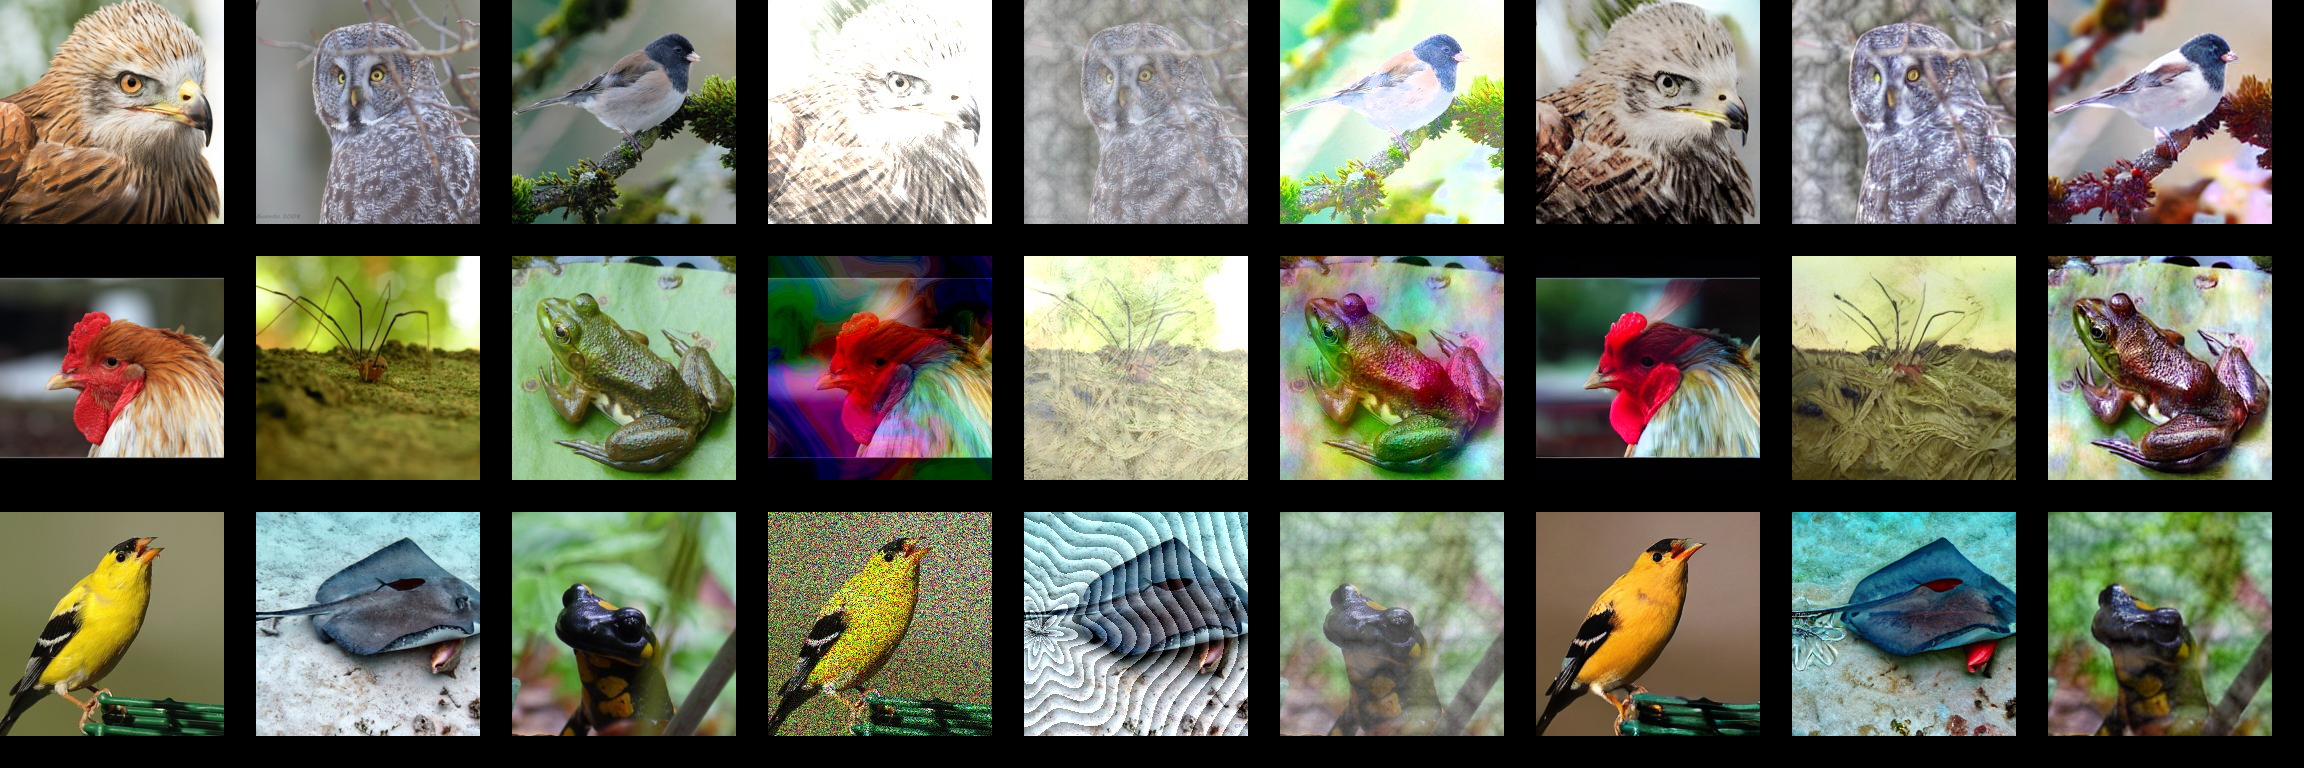

In [ ]:

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_images(images, size, shape=None, width=256, height=256):    
    # Create canvas for the final image with total size
    shape = shape if shape else (1, len(images))
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            image.paste(images[idx], offset)
    
    return image

# random seed generator
generator = torch.Generator(device="cuda").manual_seed(1)
filenames_1 = natsorted(glob('./__assets__/clean_images/*'))
filenames_2 = natsorted(glob('./__assets__/corrupt_images/*'))

# if you want to edit one corrupt image, please put PIL.Image format in the pipe. 
assert len(filenames_1) == len(filenames_2)
images_1 = [Image.open(filenames_1[i]) for i in range(len(filenames_1))]
images_2 = [Image.open(filenames_2[i]) for i in range(len(filenames_2))]

out_image = pipe(prompt=['Clean the image'] * len(filenames_2), 
            image=images_2,
            num_images_per_prompt=1,
            num_inference_steps=4, 
            generator=generator,
            guidance_scale=7.5).images 

clean_imgs   = concat_images(images_1, (256, 256), (3, 3))
corrupt_imgs = concat_images(images_2, (256, 256), (3, 3))
recon_imgs   = concat_images(out_image, (256, 256), (3, 3))

img = get_concat_h(clean_imgs, corrupt_imgs)
get_concat_h(img, recon_imgs)
# Order : (3x3) Clean, (3x3) Corrupt, and (3x3) Edited images by Decorruptor-CM

  0%|          | 0/4 [00:00<?, ?it/s]

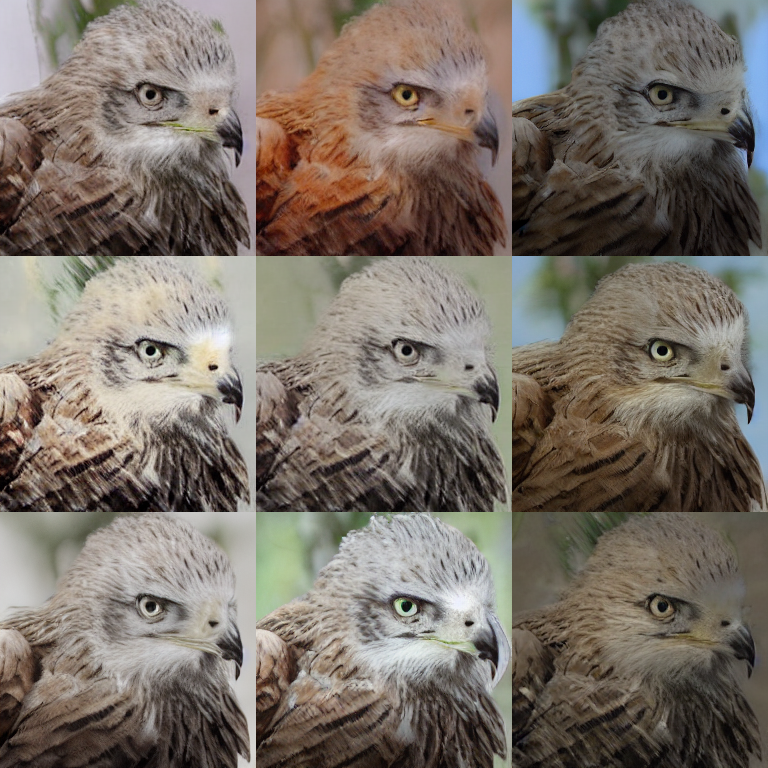

In [ ]:
image_load = Image.open('img_ex.JPEG')
generator = torch.Generator(device="cuda").manual_seed(1)

image = image_load.resize((256, 256), Image.Resampling.LANCZOS)

out_image = pipe(prompt=['Clean the image']*9, 
            image=[image]*9,
            num_images_per_prompt=1,
            num_inference_steps=4, 
            image_guidance_scale=1.1,
            generator=generator,
            guidance_scale=9).images 
concat_images(out_image, (256, 256), (3, 3))
